Episode: 100, Epsilon: 0.61, Best Reward: -230.0, Mean Reward: -966.0
Episode: 200, Epsilon: 0.37, Best Reward: -132.0, Mean Reward: -529.1
Episode: 300, Epsilon: 0.22, Best Reward: -122.0, Mean Reward: -287.8
Episode: 400, Epsilon: 0.13, Best Reward: -109.0, Mean Reward: -215.9
Episode: 500, Epsilon: 0.08, Best Reward: -93.0, Mean Reward: -187.7
Episode: 600, Epsilon: 0.05, Best Reward: -65.0, Mean Reward: -168.1
Episode: 700, Epsilon: 0.05, Best Reward: -62.0, Mean Reward: -101.4
Episode: 800, Epsilon: 0.05, Best Reward: -62.0, Mean Reward: -93.3
Episode: 900, Epsilon: 0.05, Best Reward: -62.0, Mean Reward: -89.7
Episode: 1000, Epsilon: 0.05, Best Reward: -61.0, Mean Reward: -84.0


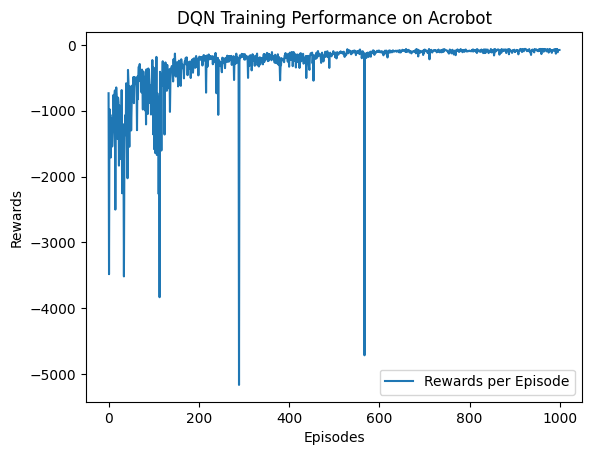

In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt


class DQNNetwork(nn.Module):
    """Red neuronal para el agente DQN."""

    def __init__(self, input_dim, output_dim):
        super(DQNNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


class DQNAgent:
    def __init__(self, env_name="Acrobot-v1", episodes=1000, gamma=0.99, lr=0.001):
        self.env = gym.make(env_name, render_mode="rgb_array")
        self.episodes = episodes
        self.gamma = gamma
        self.lr = lr
        self.epsilon = 1.0
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.995
        self.memory = []
        self.batch_size = 64
        self.replay_buffer_capacity = 10000

        self.rewards_per_episode = []
        self.best_reward = -np.inf

        # Dimensiones
        input_dim = self.env.observation_space.shape[0]
        output_dim = self.env.action_space.n

        # Inicializar la red y optimizador
        self.network = DQNNetwork(input_dim, output_dim)
        self.target_network = DQNNetwork(input_dim, output_dim)
        self.target_network.load_state_dict(self.network.state_dict())
        self.target_network.eval()

        self.optimizer = optim.Adam(self.network.parameters(), lr=self.lr)
        self.loss_fn = nn.MSELoss()

    def store_transition(self, state, action, reward, next_state, done):
        """Almacenar experiencias en la memoria de replay."""
        if len(self.memory) > self.replay_buffer_capacity:
            self.memory.pop(0)
        self.memory.append((state, action, reward, next_state, done))

    def sample_memory(self):
        """Obtener un batch aleatorio de la memoria."""
        return random.sample(self.memory, self.batch_size)

    def select_action(self, state):
        """Seleccionar acción utilizando la política epsilon-greedy."""
        if random.random() < self.epsilon:
            return self.env.action_space.sample()
        state = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            return torch.argmax(self.network(state)).item()

    def update_network(self):
        """Actualizar la red neuronal usando experiencias almacenadas."""
        if len(self.memory) < self.batch_size:
            return

        batch = self.sample_memory()
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.tensor(np.array(states), dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.int64)
        rewards = torch.tensor(rewards, dtype=torch.float32)
        next_states = torch.tensor(np.array(next_states), dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32)

        q_values = self.network(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        next_q_values = self.target_network(next_states).max(1)[0]
        expected_q_values = rewards + (1 - dones) * self.gamma * next_q_values

        loss = self.loss_fn(q_values, expected_q_values.detach())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def train(self):
        for episode in range(1, self.episodes + 1):
            state, _ = self.env.reset()
            done = False
            total_reward = 0

            while not done:
                action = self.select_action(state)
                next_state, reward, done, _, _ = self.env.step(action)
                self.store_transition(state, action, reward, next_state, done)
                self.update_network()

                state = next_state
                total_reward += reward

            self.rewards_per_episode.append(total_reward)
            self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)

            # Actualizar la red objetivo periódicamente
            if episode % 10 == 0:
                self.target_network.load_state_dict(self.network.state_dict())

            # Guardar el modelo si es la mejor recompensa
            if total_reward > self.best_reward:
                self.best_reward = total_reward
                self.save_model()

            # Imprimir métricas cada 100 episodios
            if episode % 100 == 0:
                mean_reward = np.mean(self.rewards_per_episode[-100:])
                print(
                    f"Episode: {episode}, Epsilon: {self.epsilon:.2f}, "
                    f"Best Reward: {self.best_reward:.1f}, Mean Reward: {mean_reward:.1f}"
                )

        self.plot_rewards()

    def save_model(self):
        """Guardar el modelo entrenado."""
        torch.save(self.network.state_dict(), "acrobot_dqn_model.pth")

    def load_model(self):
        """Cargar el modelo entrenado."""
        self.network.load_state_dict(torch.load("acrobot_dqn_model.pth"))
        self.network.eval()

    def plot_rewards(self):
        """Graficar las recompensas acumuladas."""
        plt.plot(self.rewards_per_episode, label="Rewards per Episode")
        plt.xlabel("Episodes")
        plt.ylabel("Rewards")
        plt.title("DQN Training Performance on Acrobot")
        plt.legend()
        plt.show()


if __name__ == "__main__":
    agent = DQNAgent(episodes=1000)
    agent.train()

In [5]:
import gymnasium as gym
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import random
import matplotlib.pyplot as plt


class DQNAgent:
    def __init__(self, env_name="Acrobot-v1", episodes=1000, gamma=0.99, lr=0.001):
        self.env = gym.make(env_name)
        self.episodes = episodes
        self.gamma = gamma  # Factor de descuento
        self.lr = lr  # Tasa de aprendizaje
        self.epsilon = 0.99  # Tasa de exploración inicial
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.995
        self.memory = []  # Memoria de replay
        self.batch_size = 256
        self.replay_buffer_capacity = 10000

        self.rewards_per_episode = []
        self.best_reward = -np.inf

        # Dimensiones
        self.input_dim = self.env.observation_space.shape[0]
        self.output_dim = self.env.action_space.n

        # Inicializar la red y el optimizador
        self.network = self.build_model()
        self.target_network = self.build_model()
        self.update_target_network()

    def build_model(self):
        """Construye el modelo de red neuronal."""
        model = keras.Sequential()
        model.add(layers.Input(shape=(self.input_dim,)))
        model.add(layers.Dense(128, activation="relu"))
        model.add(layers.Dense(128, activation="relu"))
        model.add(layers.Dense(self.output_dim))
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=self.lr), loss="mse"
        )
        return model

    def update_target_network(self):
        """Actualiza los pesos de la red objetivo."""
        self.target_network.set_weights(self.network.get_weights())

    def store_transition(self, state, action, reward, next_state, done):
        """Almacenar experiencias en la memoria de replay."""
        if len(self.memory) > self.replay_buffer_capacity:
            self.memory.pop(0)
        self.memory.append((state, action, reward, next_state, done))

    def sample_memory(self):
        """Obtener un batch aleatorio de la memoria."""
        return random.sample(self.memory, self.batch_size)

    def select_action(self, state):
        """Seleccionar acción utilizando la política epsilon-greedy."""
        if random.random() < self.epsilon:
            return self.env.action_space.sample()
        state = np.array(state).reshape(-1, self.input_dim)
        q_values = self.network.predict(state, verbose=0)
        return np.argmax(q_values[0])

    def update_network(self):
        """Actualizar la red neuronal usando experiencias almacenadas."""
        if len(self.memory) < self.batch_size:
            return

        batch = self.sample_memory()
        states, actions, rewards, next_states, dones = zip(*batch)

        states = np.array(states)
        next_states = np.array(next_states)
        actions = np.array(actions)
        rewards = np.array(rewards)
        dones = np.array(dones).astype(float)

        # Predecir Q(s,a) y Q(s',a') usando la red actual y la red objetivo
        q_values = self.network.predict(states, verbose=0)
        next_q_values = self.target_network.predict(next_states, verbose=0)

        # Actualizar los Q-values para las acciones tomadas
        for i in range(self.batch_size):
            target = rewards[i]
            if not dones[i]:
                target += self.gamma * np.max(next_q_values[i])
            q_values[i][actions[i]] = target

        # Entrenar la red con los estados y Q-values actualizados
        self.network.fit(states, q_values, epochs=1, verbose=0)

    def train(self):
        for episode in range(1, self.episodes + 1):
            state, _ = self.env.reset()
            done = False
            total_reward = 0

            while not done:
                action = self.select_action(state)
                next_state, reward, done, _, _ = self.env.step(action)
                self.store_transition(state, action, reward, next_state, done)
                self.update_network()

                state = next_state
                total_reward += reward

            self.rewards_per_episode.append(total_reward)
            self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)

            # Actualizar la red objetivo periódicamente
            if episode % 10 == 0:
                self.update_target_network()

            # Guardar el modelo si es la mejor recompensa
            if total_reward > self.best_reward:
                self.best_reward = total_reward
                self.save_model()

            mean_reward = np.mean(self.rewards_per_episode)
            print(
                f"Episodio: {episode}, Epsilon: {self.epsilon:.2f}, "
                f"Mejor Recompensa: {self.best_reward:.1f}, Recompensa Promedio: {mean_reward:.1f}"
            )

        self.plot_rewards()

    def save_model(self):
        """Guardar el modelo entrenado."""
        self.network.save("acrobot_dqn_model.keras")

    def load_model(self):
        """Cargar el modelo entrenado."""
        self.network = keras.models.load_model("acrobot_dqn_model.keras")
        self.update_target_network()

    def plot_rewards(self):
        """Graficar las recompensas acumuladas."""
        plt.plot(self.rewards_per_episode, label="Recompensa por Episodio")
        plt.xlabel("Episodios")
        plt.ylabel("Recompensa")
        plt.title("Rendimiento del Entrenamiento DQN en Acrobot")
        plt.legend()
        plt.show()


if __name__ == "__main__":
    agent = DQNAgent(episodes=5)
    agent.train()


Episodio: 1, Epsilon: 0.99, Mejor Recompensa: -1318.0, Recompensa Promedio: -1318.0
Episodio: 2, Epsilon: 0.98, Mejor Recompensa: -1318.0, Recompensa Promedio: -4229.5


KeyboardInterrupt: 